In [76]:
import os 
import numpy as np
import tensorflow as tf
import shutil
import pandas as pd
import matplotlib.pyplot as plt


In [77]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing import image
import os

In [78]:
model = tf.keras.models.load_model('image_classification_model.h5')

In [79]:


diretorio = f'data/test/'

imagens = []
resposta = []

#percorre cada arquivo do diretorio
for root, dirs, files in os.walk(diretorio):
    for arquivo in files:
        img_path = os.path.join(root, arquivo)

        img = image.load_img(img_path, target_size=(128, 128))  # Substitua o tamanho alvo conforme necessário
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array /= 255.0  # Normalização da imagem (se não foi feito durante o treinamento)
        imagens.append(img_array)
        resposta.append(root.split('/')[-1])

In [80]:
df = pd.DataFrame({'imagem':imagens, 'classe' : resposta})
df.head()

,imagem,classe
0,"[[[[0.09019608 0.09411765 0.17254902], [0.0901...",agua
1,"[[[[0.12941177 0.14509805 0.19215687], [0.1294...",agua
2,"[[[[0.32941177 0.3137255 0.2784314 ], [0.3294...",area_preservacao
3,"[[[[0.08235294 0.15686275 0.13333334], [0.0823...",area_preservacao
4,"[[[[0.02352941 0.05882353 0.04705882], [0.0235...",area_preservacao


In [81]:
class_names = ['agua', 'area_preservacao', 'construcao', 'estrada', 'eucalipto', 'pasto', 'plantacao']  # Lista das classes em ordem

predict_prob = []
df['predict'] = np.nan

for i in range(df.shape[0]):
    imagem = df['imagem'].iloc[i]
    
    predictions = model.predict(imagem)

    # # Obtenha a classe prevista
    class_index = np.argmax(predictions)
    predicted_class = class_names[class_index]

    df['predict'].iloc[i] = predicted_class
    predict_prob.append(predictions)
df['predict_prob'] = predict_prob


1/1 [==============================] - 0s 32ms/step


c:\Users\55119\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


1/1 [==============================] - 0s 26ms/step


In [82]:
pd.pivot_table(df,
               index = 'classe',
               columns = 'predict',
               values = 'imagem',
               aggfunc=len,
               margins = True).fillna(0)

predict,agua,area_preservacao,construcao,estrada,eucalipto,pasto,plantacao,All
classe,,,,,,,,
agua,2.0,0.0,0.0,0.0,0.0,0.0,0.0,2
area_preservacao,0.0,32.0,1.0,2.0,2.0,0.0,0.0,37
construcao,0.0,0.0,10.0,10.0,0.0,0.0,0.0,20
estrada,0.0,0.0,8.0,24.0,0.0,1.0,1.0,34
eucalipto,11.0,22.0,0.0,1.0,26.0,0.0,0.0,60
pasto,8.0,0.0,0.0,2.0,0.0,11.0,5.0,26
plantacao,0.0,0.0,3.0,2.0,0.0,0.0,8.0,13
All,21.0,54.0,22.0,41.0,28.0,12.0,14.0,192


In [83]:
acuracia  = (df[df['classe'] == df['predict']].shape[0]/ df.shape[0])*100
print(f'O modelo tem {round(acuracia, 2)}% para os dados de teste')

O modelo tem 58.85% para os dados de teste


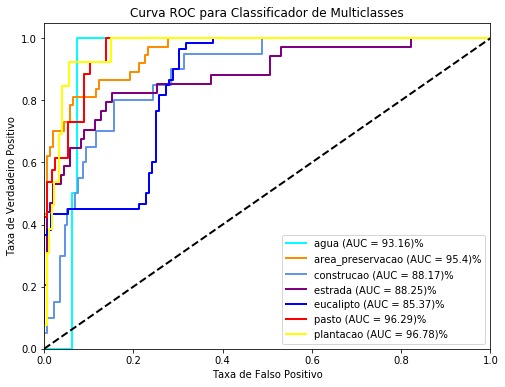

0.9191615528368703

In [84]:
from sklearn.metrics import roc_curve, auc
from itertools import cycle

def plot_roc_auc_multiclass(df_ ,y_true, y_score, classes):
    """
    Plota a curva ROC e calcula a AUC para um classificador de multiclasses usando a abordagem "one-vs-all".

    Parâmetros:
    - y_true: Rótulos verdadeiros (array 1D)
    - y_score: Pontuações do classificador para cada classe (array 2D)
    - n_classes: Número de classes

    Retorno:
    - Plota a curva ROC para cada classe e retorna a AUC média.
    """

    df = df_.copy()

    n_classes = len(classes)

    # Binariza os rótulos verdadeiros
    for c in classes:
        df[c] = np.where(df[y_true] == c, 1, 0)

    # Inicializa variáveis para armazenar as taxas de falso positivo e verdadeiro positivo
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # Calcula a curva ROC e a AUC para cada classe
    for i in range(n_classes):
        fpr[class_names[i]], tpr[class_names[i]], _ = roc_curve(df[class_names[i]], df[y_score].apply(lambda x: x[0][i]))
        roc_auc[class_names[i]] = auc(fpr[class_names[i]], tpr[class_names[i]])

    # Calcula a média das AUCs de todas as classes
    auc_macro = np.mean(list(roc_auc.values()))

    # Plota a curva ROC para cada classe
    plt.figure(figsize=(8, 6))
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'purple', 'blue', 'red', 'yellow'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[class_names[i]], tpr[class_names[i]], color=color, lw=2, label=f'{class_names[i]} (AUC = {round(roc_auc[class_names[i]]*100, 2)})%')

    # Plota a linha diagonal (sem discriminação)
    plt.plot([0, 1], [0, 1], 'k--', lw=2)

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taxa de Falso Positivo')
    plt.ylabel('Taxa de Verdadeiro Positivo')
    plt.title('Curva ROC para Classificador de Multiclasses')
    plt.legend(loc="lower right")
    plt.show()

    return auc_macro

class_names = ['agua', 'area_preservacao', 'construcao', 'estrada', 'eucalipto', 'pasto', 'plantacao']
plot_roc_auc_multiclass(df, 'classe', 'predict_prob',class_names)

In [85]:
df

,imagem,classe,predict,predict_prob
0,"[[[[0.09019608 0.09411765 0.17254902], [0.0901...",agua,agua,"[[0.57072407, 0.4271606, 0.00047775178, 0.0008..."
1,"[[[[0.12941177 0.14509805 0.19215687], [0.1294...",agua,agua,"[[0.6476678, 0.350179, 0.00052739825, 0.000991..."
2,"[[[[0.32941177 0.3137255 0.2784314 ], [0.3294...",area_preservacao,area_preservacao,"[[1.0599933e-07, 0.99996805, 8.875841e-07, 1.3..."
3,"[[[[0.08235294 0.15686275 0.13333334], [0.0823...",area_preservacao,area_preservacao,"[[2.965931e-06, 0.9641862, 6.5702857e-06, 1.31..."
4,"[[[[0.02352941 0.05882353 0.04705882], [0.0235...",area_preservacao,area_preservacao,"[[1.5182303e-05, 0.9998234, 2.4113488e-05, 2.5..."
...,...,...,...,...
187,"[[[[0.40392157 0.3647059 0.3254902 ], [0.4039...",plantacao,construcao,"[[2.0865565e-19, 3.403844e-21, 0.99486876, 0.0..."
188,"[[[[0.3529412 0.28235295 0.22745098], [0.3529...",plantacao,plantacao,"[[4.8932854e-11, 6.20316e-13, 0.03212613, 0.02..."
189,"[[[[0.4627451 0.4117647 0.3882353], [0.4627451...",plantacao,plantacao,"[[8.417558e-10, 7.9594545e-13, 0.00973345, 0.0..."
190,"[[[[0.43529412 0.38431373 0.34901962], [0.4352...",plantacao,plantacao,"[[3.3213112e-08, 7.771146e-11, 0.0017424333, 0..."
